In [527]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# # import pickle file 
with open('../scenario-properties-controller.pkl', 'rb') as f:
    baseline = pickle.load(f)

# with open('../scenario-properties-controller_orig.pkl', 'rb') as f:
#     baseline = pickle.load(f)


# "mass": [0.0156, 0.5, 1],
#             "radius": [0.0625, 0.125, 0.25],

# "mass": [0.0156, 0.5, 1, 8],
#             "radius": [0.0625, 0.125, 0.25, 0.5],


# ,
#         {
#             "sym_name": "D",
#             "Cd": 2.2,
#             "mass": 200,
#             "A": 5,
#             "radius": 1.25,
#             "active": false,
#             "maneuverable": false,
#             "trackable": false,
#             "deltat": null,
#             "Pm": 0,
#             "alpha": 0,
#             "alpha_active": 0,
#             "RBflag": 0,
#             "slotting_effectiveness": 0,
#             "drag_effected": true,
#             "launch_func": "launch_func_null",
#             "pmd_func": "pmd_func_none",
#             "drag_func": "drag_func_exp"
#         }

# ## Constraints for trust-constr: lb <= fun(x) <= ub
# nonlcon = NonlinearConstraint(lambda x: PrcAll(x, baseline), 0, 0)
# # # nonlcon = NonlinearConstraint(lambda x: PrcAll(x, baseline), 0, 1e-8)
# ## Options for trust-constr
# options = {
#     'disp': True,           
#     # 'maxiter': 5e5,       
#     # 'xtol': 1e-18,           
#     'gtol': 1e1,
# }

In [528]:
import sympy as sp

# Equations
baseline.equations

# x0 initial population
baseline.x0

# baseline.
baseline.all_symbolic_vars

# solver
equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]

for i1 in range(baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1]+full_lambda_flattened[i1]

baseline.all_symbolic_vars = baseline.all_symbolic_vars + full_lambda_flattened

equations = [sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy') for eq in equations_flattened]

In [536]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.integrate import solve_ivp

def PrfAll(x, baseline):
  """
  Python version of the PrfAll function.

  Args:
    x: Input array, where the first N_shell elements represent S_all.
    baseline: Dictionary containing data, including 'N_shell'.

  Returns:
    f: Objective function.
  """

  N_shell = baseline.n_shells
  S_all = x[:N_shell]  # Extract S_all from x

  # HIGH CAPACITY
  # f = -np.sum(np.log(S_all)**1)
  f = -np.sum(np.log(S_all)**2) 
  # f = -np.sum(np.log(S_all)**3) 
  # f = 1/np.sum(S_all) 

  # Uncomment for NOT HIGH CAPACITY scenarios (as needed)
  # f = - np.sum(np.log(S_all[5:8])) # shells at 500-600 km (Python index starts at 0)
  # f = - np.sum(S_all[6]) # shell at 550 km (Python index starts at 0)

  return f

def PrcAll(x, baseline):
    """
    Evaluates all constraints at once.

    Args:
      x: The optimization variables.
      baseline: Your baseline object containing symbolic variables.

    Returns:
      An array containing the results of all constraint function evaluations.
    """

    c_eq = np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*x) for eq in equations_flattened])
    
    # c_ineq 
    # y_fail_l(k) = -(lambda * Dt * (1 - failure_rate_L) - S);
    # y_fail_u(k) = lambda * Dt * (1 - failure_rate_U) - S; 

    return c_eq

## Initial guess
x0 = np.ones(len(baseline.all_symbolic_vars)) * 0

## Bounds
lb = np.ones(len(baseline.all_symbolic_vars)) * 1
ub = np.inf

## Objective function
objective = PrfAll

## Constraints for SLSQP
con1 = {'type': 'eq', 'fun': lambda x: PrcAll(x, baseline)}
# con2 = {'type': 'ineq', 'fun': constraint2}
nonlcon = con1

## Options for SLSQP
options = {
    'disp': True,   
    # 'maxiter': 5e5,
    'ftol': 1e-6,     
    'eps': 1e-18,     
}

## Perform the optimization
result = minimize(objective, x0, args=(baseline), method='SLSQP',
                  jac=None, hess=None, hessp=None, 
                  bounds = Bounds(lb=lb, ub=ub, keep_feasible=False), 
                  constraints = nonlcon,
                  options = options)

## Print the results
print("Optimal found at:", result.x)
print("Function value at optimal:", -result.fun)
print("Equality constraints:", np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*result.x) for eq in equations_flattened]))
result

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2422.3718139260036
            Iterations: 93
            Function evaluations: 4063
            Gradient evaluations: 93
Optimal found at: [1.42200331e+06 3.53024556e+06 1.41330884e+06 1.42048222e+06
 1.29209289e+06 1.28360642e+06 1.34606960e+06 1.32852350e+06
 5.02793347e+05 2.77033238e+05 1.19701971e+05 3.37415652e+04
 4.19033216e+04 3.79797834e+04 1.20370158e+00 4.60815484e+00
 1.35894145e+01 3.38886683e+01 8.30936416e+01 1.78202703e+02
 3.26073028e+02 3.90261523e+02 3.57599190e+01 1.57566253e+01
 4.86471493e+00 2.38466675e+00 2.71107265e+00 1.00000000e+00
 1.77750425e+05 4.41280805e+05 1.76663732e+05 1.77560592e+05
 1.61512303e+05 1.60452255e+05 1.68261448e+05 1.66068636e+05
 6.28492778e+04 3.46291809e+04 1.49627498e+04 4.21769612e+03
 5.23791586e+03 4.74747314e+03]
Function value at optimal: 2422.3718139260036
Equality constraints: [-2.91038305e-11  6.98491931e-10  1.51339918e-09 -4.1036400

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -2422.3718139260036
       x: [ 1.422e+06  3.530e+06 ...  5.238e+03  4.747e+03]
     nit: 93
     jac: [-1.993e-05 -8.542e-06 ...  0.000e+00  0.000e+00]
    nfev: 4063
    njev: 93

In [537]:
N_shell = baseline.n_shells
R02 = baseline.R0_km
xopt = result.x

S_opt = xopt[0:N_shell]
N_opt = xopt[N_shell:2*N_shell] 
# D_opt = xopt[2*N_shell:3*N_shell]
# lam_opt = xopt[3*N_shell:4*N_shell]
lam_opt = xopt[2*N_shell:3*N_shell]

c_eq = np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*xopt) for eq in equations_flattened])
S_eq = c_eq[0:N_shell]
N_eq = c_eq[N_shell:2*N_shell]
# D_eq = c_eq[2*N_shell:3*N_shell]

# var = baseline.all_symbolic_vars[:3*N_shell]
# lam = baseline.all_symbolic_vars[3*N_shell:]
var = baseline.all_symbolic_vars[:2*N_shell]
lam = baseline.all_symbolic_vars[2*N_shell:]
f3 = equations_flattened
fun3 = sp.lambdify((var, lam), f3, 'numpy')

def func(t, x, fun3, lam_opt):
    """ODE system function for solve_ivp."""
    return np.array(fun3(x, np.array(lam_opt))).flatten()

tf_ss = 100
tspan1 = np.linspace(0, tf_ss, 100)
sol = solve_ivp(func, (0, tf_ss), xopt[:2*N_shell], 
                method=baseline.integrator,
                t_eval=tspan1, 
                args=(fun3,lam_opt),
                rtol=1e-8, atol=1e-8)

t_prop = sol.t
x_prop = sol.y

S_prop = x_prop[0:N_shell]
N_prop = x_prop[N_shell:2*N_shell]
# D_prop = x_prop[2*N_shell:3*N_shell]
# N_tot = S_prop + D_prop + N_prop
N_tot = S_prop + N_prop
N_tot_sum = sum(N_tot,2)
S_sum = sum(S_prop,2)
# D_sum = sum(D_prop,2)
N_sum = sum(N_prop,2)

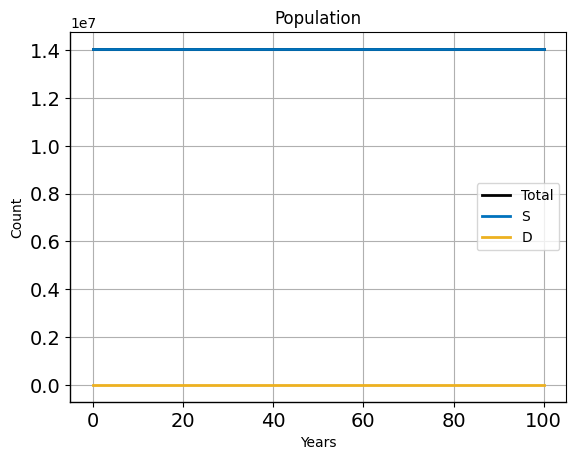

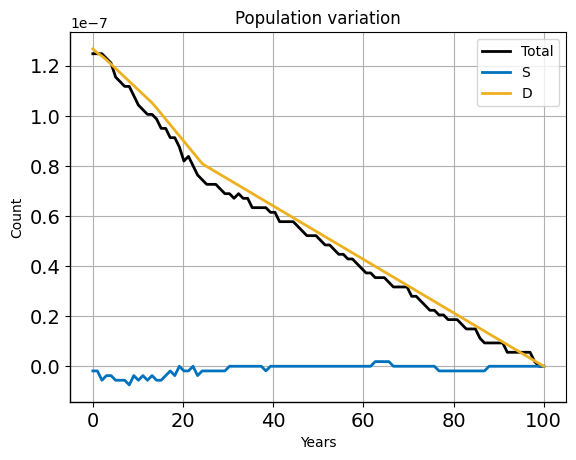

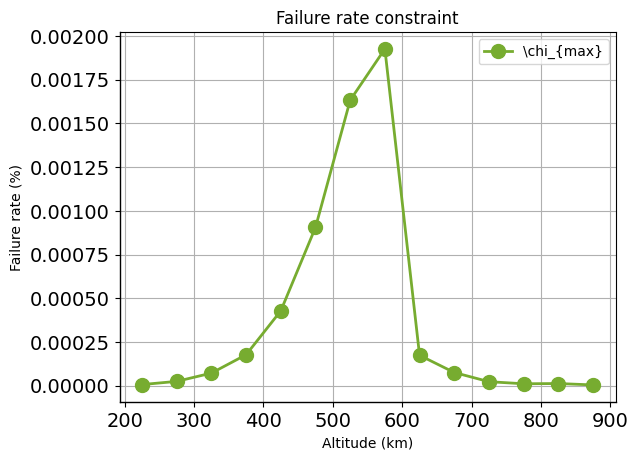

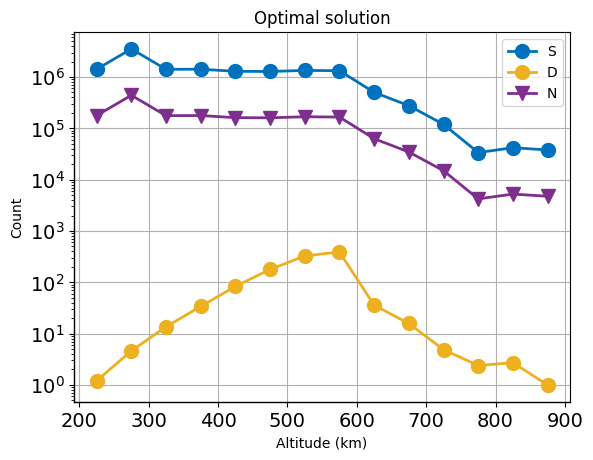

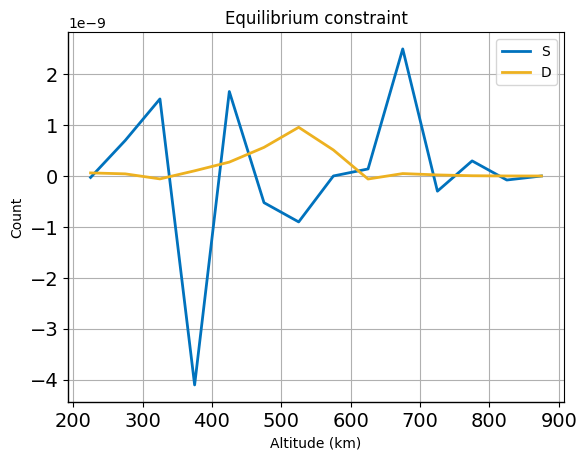

In [538]:
# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 2
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14
Dt = 8

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop, N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
plt.plot(t_prop, S_sum, color=colors[1], linewidth=sel_LineWidth)
# plt.plot(t_prop, D_sum, color=colors[2], linewidth=sel_LineWidth)
plt.plot(t_prop, N_sum, color=colors[3], linewidth=sel_LineWidth)
plt.title("Population")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(["Total", "S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop, N_tot_sum[-1] - N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
plt.plot(t_prop, S_sum[-1] - S_sum, color=colors[1], linewidth=sel_LineWidth)
# plt.plot(t_prop, D_sum[-1] - D_sum, color=colors[2], linewidth=sel_LineWidth)
plt.plot(t_prop, N_sum[-1] - N_sum, color=colors[3], linewidth=sel_LineWidth)
plt.title("Population variation")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(["Total", "S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
# plt.plot(R02[1:] - 25, 100 * failure_rate_U * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, 100 * (Dt * lam_opt - S_opt) / (Dt * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Failure rate constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Failure rate (%)")
plt.legend(["\chi_{max}"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("fail_rate_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.semilogy(R02[1:] - 25, S_opt, '-o', color=colors[1], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.grid(True)
# plt.semilogy(R02[1:] - 25, D_opt, '-o', color=colors[2], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, N_opt, '-o', color=colors[3], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, lam_opt, '-v', color=colors[4], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Optimal solution")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N", "\lambda"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("max_capacity_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(R02[1:] - 25, S_eq, color=colors[1], linewidth=sel_LineWidth)
# plt.plot(R02[1:] - 25, D_eq, color=colors[2], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, N_eq, color=colors[3], linewidth=sel_LineWidth)
plt.title("Equilibrium constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("equil_constr_no_fail.pdf", dpi=300)  


In [422]:
# from scipy.optimize import show_options
# show_options('minimize', method='SLSQP')
# show_options('minimize', method='trust-constr')